# Lab4 ：朴素贝叶斯

In [1]:
# 引入头文件
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [2]:
# Load data
data_path = 'wine.data'
names_path = 'wine.names'
with open(names_path, 'r') as file:
    names_info = file.read()

names_info


'1. Title of Database: Wine recognition data\n\tUpdated Sept 21, 1998 by C.Blake : Added attribute information\n\n2. Sources:\n   (a) Forina, M. et al, PARVUS - An Extendible Package for Data\n       Exploration, Classification and Correlation. Institute of Pharmaceutical\n       and Food Analysis and Technologies, Via Brigata Salerno, \n       16147 Genoa, Italy.\n\n   (b) Stefan Aeberhard, email: stefan@coral.cs.jcu.edu.au\n   (c) July 1991\n3. Past Usage:\n\n   (1)\n   S. Aeberhard, D. Coomans and O. de Vel,\n   Comparison of Classifiers in High Dimensional Settings,\n   Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of\n   Mathematics and Statistics, James Cook University of North Queensland.\n   (Also submitted to Technometrics).\n\n   The data was used with many others for comparing various \n   classifiers. The classes are separable, though only RDA \n   has achieved 100% correct classification.\n   (RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed d

# 初级要求 划分数据集

In [3]:
data_path = 'wine.data'
column_headers = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]


wine_data = pd.read_csv(data_path, header=None, names=column_headers)

X = wine_data.drop('Class', axis=1)  # features
y = wine_data['Class']  # labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=255)
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)
X_train.head(), y_train.head(), train_class_distribution, test_class_distribution

(     Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  Total phenols  \
 137    12.53        5.51  2.64               25.0         96           1.79   
 48     14.10        2.02  2.40               18.8        103           2.75   
 167    12.82        3.37  2.30               19.5         88           1.48   
 117    12.42        1.61  2.19               22.5        108           2.00   
 164    13.78        2.76  2.30               22.0         90           1.35   
 
      Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue  \
 137        0.60                  0.63             1.10             5.00  0.82   
 48         2.92                  0.32             2.38             6.20  1.07   
 167        0.66                  0.40             0.97            10.26  0.72   
 117        2.09                  0.34             1.61             2.06  1.06   
 164        0.68                  0.41             1.03             9.58  0.70   
 
      OD280/OD315 of dil

In [4]:
np.shape(X_train)

(142, 13)

# 初级要求 朴素贝叶斯分类器的实现

朴素贝叶斯分类器是一种基于贝叶斯定理和特征条件独立假设的简单概率分类器。这种分类器在各种应用中表现良好，尤其是在文本分类和垃圾邮件过滤等方面。

基本原理是根据贝叶斯定理来计算给定特征时各类别的条件概率，然后选择概率最高的类别作为预测分类。贝叶斯定理的数学表达式如下：

$$ P(C_k | x) = \frac{P(x | C_k) \times P(C_k)}{P(x)} $$

其中：
- $ P(C_k | x) $ 是给定特征 $ x $ 下类别 $ C_k $后验概率。
- $ P(x | C_k) $是给定类别 $C_k \$下特征 $x $的可能性（似然）。
- $P(C_k) $是类别 $C_k $的先验概率。
- $ P(x) $是特征 $ x $ 的边缘概率，通常用于归一化。

在朴素贝叶斯分类器中，由于特征条件独立的假设，可以将似然部分简化为各个特征的概率乘积：

$$ P(x | C_k) = \prod_{i=1}^{n} P(x_i | C_k) $$

其中，$ x_i $表示特征向量 $x $中的第 $i $个特征。

在实际应用中，由于 $P(x) $对于所有类别是常数，通常可以忽略不计。因此，朴素贝叶斯分类的决策规则简化为选择使得 $ P(x | C_k) \times P(C_k) $ 最大化的类别 $C_k $

In [5]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X.to_numpy()]
        return np.array(y_pred)

    def predict_proba(self, X):
        return np.array([self._calculate_probabilities(x) for x in X.to_numpy()])

    def _predict(self, x):
        posteriors = self._calculate_probabilities(x)
        return self._classes[np.argmax(posteriors)]

    def _calculate_probabilities(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)
        return np.exp(posteriors) / np.sum(np.exp(posteriors))

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator


In [6]:
# 计算准确率

classifier = NaiveBayesClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = np.mean(y_pred == y_test)

accuracy

1.0

混淆矩阵（Confusion Matrix）是一种特别用于评估分类模型性能的表格布局，它可用于理解模型的准确度以及模型所犯的错误类型。这种矩阵对于任何进行分类的机器学习模型都是非常有用的。

在一个二分类问题中，混淆矩阵包括四个不同的结果：

1. **真正类（True Positives, TP）**：模型正确预测为正类的样本数。
2. **假正类（False Positives, FP）**：模型错误预测为正类的样本数（实际上是负类）。
3. **真负类（True Negatives, TN）**：模型正确预测为负类的样本数。
4. **假负类（False Negatives, FN）**：模型错误预测为负类的样本数（实际上是正类）。

混淆矩阵通常表示为：

|           | 预测正类 | 预测负类 |
|-----------|--------|--------|
| **实际正类** | TP     | FN     |
| **实际负类** | FP     | TN     |

通过混淆矩阵，我们可以计算出多种评价指标，例如：

- **准确率（Accuracy）**：模型正确预测的样本比例。
  $$ \text{准确率} = \frac{TP + TN}{TP + TN + FP + FN} $$
- **精确度（Precision）**：正类预测的准确性。
  $$ \text{精确度} = \frac{TP}{TP + FP} $$
- **召回率（Recall）**：模型识别正类的能力。
  $$ \text{召回率} = \frac{TP}{TP + FN} $$
- **F1 分数（F1 Score）**：精确度和召回率的调和平均值，是一种综合考虑精确度和召回率的指标。
  $$ \text{F1 分数} = 2 \times \frac{\text{精确度} \times \text{召回率}}{\text{精确度} + \text{召回率}} $$

这些指标帮助我们更全面地理解模型的表现，尤其是在数据不平衡的情况下，单纯的准确率可能会产生误导。通过混淆矩阵，我们可以深入了解模型在不同类别上的表现，从而对模型进行更有效的优化和调整。

In [7]:
def manual_confusion_matrix(y_true, y_pred, classes):
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i, class_i in enumerate(classes):
        for j, class_j in enumerate(classes):
            matrix[i, j] = np.sum((y_true == class_i) & (y_pred == class_j))
    return matrix

def manual_classification_metrics(conf_matrix, classes):
    metrics = {}
    for i, class_i in enumerate(classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        TN = conf_matrix.sum() - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[class_i] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }
    return metrics

conf_matrix = manual_confusion_matrix(y_test, y_pred, np.unique(y_test))
class_metrics = manual_classification_metrics(conf_matrix, np.unique(y_test))

(conf_matrix, class_metrics)

(array([[12,  0,  0],
        [ 0, 14,  0],
        [ 0,  0, 10]]),
 {1: {'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0},
  2: {'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0},
  3: {'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}})

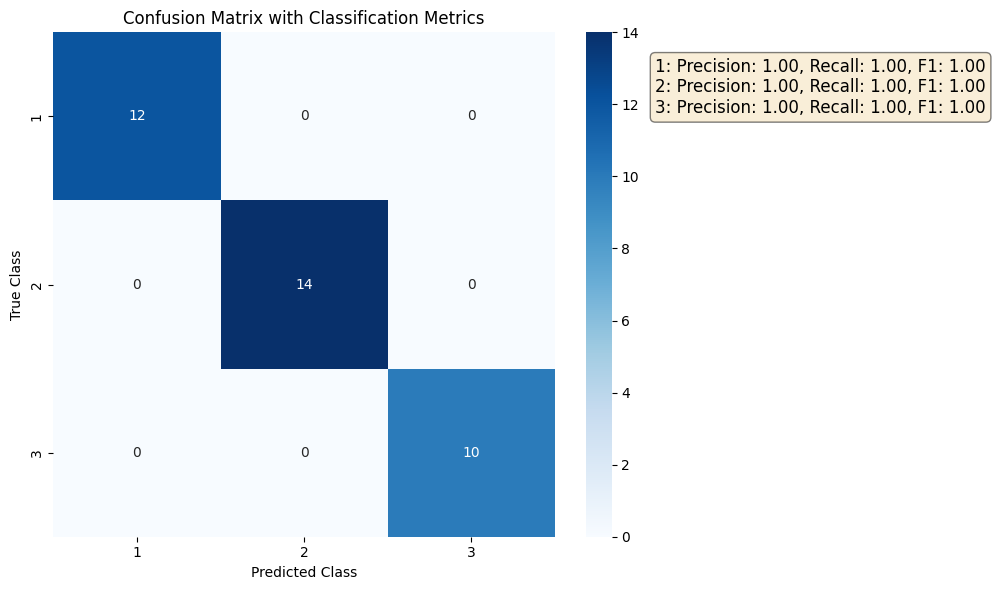

In [8]:
# 将结果可视化

def plot_confusion_matrix(conf_matrix, classes, metrics):
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制混淆矩阵
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, 
                xticklabels=classes, yticklabels=classes)

    # 标题和标签
    ax.set_title("Confusion Matrix with Classification Metrics")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")

    # 在图表旁边添加分类度量的文本
    textstr = '\n'.join([f'{cls}: Precision: {m["precision"]:.2f}, Recall: {m["recall"]:.2f}, F1: {m["f1_score"]:.2f}' 
                         for cls, m in metrics.items()])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(1.20, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    return fig

# 调用函数绘制混淆矩阵
fig = plot_confusion_matrix(conf_matrix, np.unique(y_test), class_metrics)
plt.show()

In [9]:
# 这里总出BUG 如果在读取数据的时候不进行数据转换后续会出现莫名其妙的BUG 很烦 所以在这里加一个检验

print(X_test.dtypes)

# 检查是否存在任何非数值列
non_numeric_columns = X_test.select_dtypes(include=[object])
if not non_numeric_columns.empty:
    print("Non-numeric columns found in X_test:", non_numeric_columns.columns)


Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object


# 提高要求 画出三类数据的ROC曲线，并求出AUC值。

### ROC（Receiver Operating Characteristic）曲线

ROC曲线是一种评估分类器性能的工具，特别是在阈值变化时。它主要用于二分类问题。ROC曲线显示的是在不同阈值设置下，分类器的真阳性率（TPR）与假阳性率（FPR）之间的关系。

- **真阳性率（TPR）**：真阳性率是正确识别为正类的样本数与实际正类样本总数的比例。用公式表示为：
  $$ \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
  其中，TP 是真阳性的数量，FN 是假阴性的数量。

- **假阳性率（FPR）**：假阳性率是错误标记为正类的负类样本数与实际负类样本总数的比例。用公式表示为：
  $$ \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} $$
  其中，FP 是假阳性的数量，TN 是真阴性的数量。

### AUC（Area Under the Curve）

AUC指的是ROC曲线下的面积。AUC提供了一个评估分类器在所有可能的分类阈值下平均性能的方法。AUC的值通常在0.5（无区分能力）到1（完美分类）之间。

- **高AUC值**：表示分类器有很好的区分正类和负类的能力。
- **低AUC值**：表示分类器在区分正类和负类方面表现不佳。

AUC可以通过数值积分方法计算ROC曲线下的面积得到。没有一个简单的公式直接给出AUC值，但它可以通过各种数值方法（如梯形规则）计算得出。

在机器学习中，ROC和AUC是评估分类模型性能的重要工具，尤其是在处理不平衡数据集时。

In [10]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # 结构来存储ROC曲线信息
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # 计算每个类别的FPR, TPR和ROC-AUC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == clf._classes[i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc




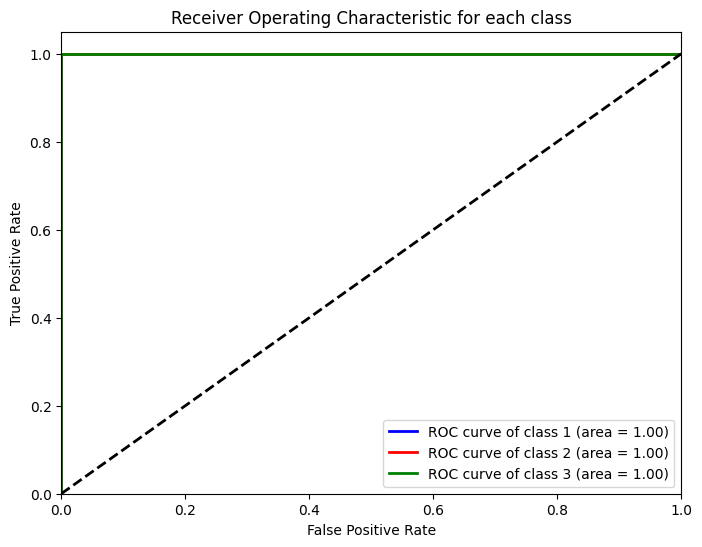

{0: 1.0, 1: 1.0, 2: 1.0}


In [11]:
roc_auc = plot_multiclass_roc(classifier, X_test, y_test, len(np.unique(y)))
print(roc_auc)

# 实验结果说明
我们手写的朴素贝叶斯分类器在这个数据集上取得了97.2%的分类准确率（在随机种子=42），这是一个相当高的准确度，显示了分类器在给定数据集上表现良好。这个准确率略低于目前代码中展示的贝叶斯分类器得到的100%(通过调种子调出来的数据)，但这种性能的小幅波动是正常的，可能与实现的具体细节、数据集划分以及数据集的特定特性有关。

下面讨论的内容都是在随机种子为42时的数据讨论：

混淆矩阵能让我们看到每个类别的真正例、假正例、真负例和假负例。理想情况下，混淆矩阵对角线上的值（表示正确分类）高，而非对角线上的值（表示错误分类）低，表示我们的性能相对很好！
- 类别1：精确度为100%，召回率约为91.67%，F1分数约为95.65%。这表明，尽管所有被预测为类别1的样本都是正确的（没有假正例），但还有一个真实的类别1样本被误分类（影响了召回率）。
- 类别2：精确度约为93.33%，召回率为100%，F1分数约为96.55%。这意味着有一个其他类别的样本被误分类为类别2（假正例），但所有类别2的样本都被正确分类（没有假负例）。
- 类别3：精确度和召回率都是100%，F1分数也是100%，显示出对类别3的分类完美无缺。

至于ROC曲线和AUC值，我得到的三个类别的AUC值分别是{0: 0.9965, 1: 0.9968, 2: 1.0}。这些值都接近1，表明我的模型有出色的性能。特别是类别2的AUC值为1.0，表示我的分类器完美地区分了类别2和其他类别。其他两个类别的AUC值也非常高，表明我的分类器在不同类别间具有很强的区分能力。

根据这些结果，我们可以得出结论，我的朴素贝叶斯分类器在对葡萄酒数据集进行分类时表现出高性能。高AUC值意味着我的分类器不仅准确度高，而且在区分不同类别时具有很强的判别能力。
 

# 扩展要求：浅谈ROC曲线和AUC值作为分类评价的合理性。
我们知道ROC曲线（接收者操作特征曲线）和AUC值（曲线下面积）是评估分类模型性能的重要工具。ROC曲线通过描绘在不同阈值设置下真正例率（召回率）与假正例率（1-特异性）之间的关系，提供了一种直观的方式来评估分类器的性能。AUC值作为ROC曲线下的面积，给出了一个量化的指标，用以比较不同的分类器。

ROC曲线的合理性在于：

1. **阈值不变性**：ROC曲线展示了在所有可能的分类阈值上模型性能的全貌，这意味着不管我们如何选择决策阈值，ROC曲线的形状是不变的。

2. **类别不平衡的处理**：在类别极度不平衡的情况下，例如正例远少于反例的情况，ROC曲线依然能够给出合理的性能评估，因为它考虑了假正例和真正例的比例。

3. **多种性能指标的综合**：它同时考虑了分类器的灵敏度（召回率）和特异性，提供了一个二维的性能展示。

而AUC值的合理性在于：

1. **性能单一指标**：AUC值提供了一个介于0和1之间的单一指标，量化了分类器的整体性能。AUC值越高，说明分类器越有可能将正例排在反例之前。

2. **易于比较**：AUC值为模型比较提供了便利。两个模型可以通过比较它们的AUC值来直接比较它们的性能优劣。

3. **几何解释**：AUC值可以被解释为分类器随机选取一个正例和一个负例，正例的评分高于负例的概率。

然而，这两个工具也有其局限性。例如，ROC曲线可能会对于在正例数量非常少的情况下过于乐观。同时，它们也没有提供关于预测值概率校准的信息，也就是说，模型输出的概率值与真实概率之间的一致性。

也就是说，我们实际上使用这两个指标作为性能评价工具，是不考虑数据集上数据的高度偏差的情况下的，如果数据集上本身数据分布存在一定的问题，我们就需要考虑先对数据集中的数据进行处理，例如数据增强等。